# Spaceship Titanic - Ninth Model

## Overview

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, 
the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets 
orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic
collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000
years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the 
Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal
records recovered from the ship's damaged computer system.

## File and Data Field Descriptions

### train.csv 

Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

Sure! Here's the code converted to a markdown table:

| Column Name | Description |
|------------- |-------------|
| `PassengerId` | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| `HomePlanet` | The planet the passenger departed from, typically their planet of permanent residence. |
| `CryoSleep` | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| `Cabin` | The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| `Destination` | The planet the passenger will be debarking to. |
| `Age` | The age of the passenger. |
| `VIP` | Whether the passenger has paid for special VIP service during the voyage. |
| `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` | Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. |
| `Name` | The first and last names of the passenger. |
| `Transported` | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

### test.csv

Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. 

Your task is to predict the value of Transported for the passengers in this set.
    
### sample_submission.csv

A sample submission file in the correct format.

| Column Name | Description |
|------------- |-------------|
| `PassengerId` | A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. |
| `Transported` | Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict. |

**Note this is based on the starter notebook here https://www.kaggle.com/code/gusthema/spaceship-titanic-with-tfdf/notebook**

In [204]:
model='ninth'

In [205]:
# Library imports

# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing

## Load Data

In [206]:
# Load the data - to pandas dataframes

test_df = pd.read_csv('./inputs/test.csv')
test_idx = test_df['PassengerId']
train_df = pd.read_csv('./inputs/train.csv')

## Drop unrequired features & add engineered ones

In [207]:
# split cabin into components
def split_cabin(name:str):
    if pd.isnull(name): # protect against empty values
        return (np.nan, np.nan, np.nan)
    parts = name.split('/')
    deck = parts[0]
    side = parts[-1]
    number = ' '.join(parts[1:-1])
    return (deck, number, side)

# This function will drop and add required features
def feature_manipulation(d : pd.DataFrame) -> pd.DataFrame:
    # print the shape of the provided dataframe
    print("Before: ", d.shape)
    # Clone the provided dataframe
    df = d.copy()
    
    # Location
    df['Deck'], df['Cabin_num'], df['Side'] = zip(*df['Cabin'].map(split_cabin))
    df['DeckSide'] = df['Deck'] + df['Side'] # Combine Deck and Side

    # Group related columns
    df['Group'] = df['PassengerId'].map(lambda x: x.split('_')[0])
    df['GroupSize'] = df['Group'].map(df['Group'].value_counts())
    
    print("After: ", df.shape)
    return df

In [208]:
train_df = feature_manipulation(train_df)

Before:  (8693, 14)
After:  (8693, 20)


In [209]:
test_df = feature_manipulation(test_df)

Before:  (4277, 13)
After:  (4277, 19)


In [210]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side,DeckSide,Group,GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,BP,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,FS,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,AS,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,AS,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,FS,0004,1


In [211]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Cabin_num,Side,DeckSide,Group,GroupSize
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S,GS,0013,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S,FS,0018,1
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S,CS,0019,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S,CS,0021,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S,FS,0023,1


## Handle Missing Data

In the first model we had a complicated approach - here we will just use the median for numeric and mode for non-numeric

In [212]:
# Define a function to print missing data
def print_missing(train: pd.DataFrame, test: pd.DataFrame):
    missing_data = pd.DataFrame({
        'Train Missing': train.isnull().sum(),
        'Test Missing': test.isnull().sum()
    }).sort_values(by='Train Missing', ascending=False)

    print(missing_data)

In [213]:
# Check for missing data before imputing
print_missing(train_df, test_df)

              Train Missing  Test Missing
CryoSleep               217          93.0
ShoppingMall            208          98.0
VIP                     203          93.0
HomePlanet              201          87.0
Name                    200          94.0
Cabin                   199         100.0
Cabin_num               199         100.0
Deck                    199         100.0
DeckSide                199         100.0
Side                    199         100.0
VRDeck                  188          80.0
FoodCourt               183         106.0
Spa                     183         101.0
Destination             182          92.0
RoomService             181          82.0
Age                     179          91.0
GroupSize                 0           0.0
PassengerId               0           0.0
Group                     0           0.0
Transported               0           NaN


### Define functions to replace data

In [214]:
def fill_with_median(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].median())
    return df

def fill_with_mode(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    return df

def fill_with_mean(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].mean())
    return df

# Here we provide a list of other_features - if a row has a nan in a feature we will fill it with the mean of the other_features in its row 
def fill_with_mean_of_other_features(df, features, other_features):
    for feature in features:
        df[feature] = df[feature].fillna(df[other_features].dropna().mean(axis=1))
    return df

def fill_with_constant(df, features, constant):
    for feature in features:
        df[feature] = df[feature].fillna(constant)
    return df

### Apply simple rules for empty data

In [215]:
def handle_empty_data(df: pd.DataFrame) -> pd.DataFrame:
   
    # fill in missing values with a constant
    df = fill_with_constant(df, ['VIP'], False)
    df = fill_with_constant(df, ['Name', 'Cabin', 'Cabin_num', 'Deck', 'Side', 'DeckSide', 'HomePlanet', 'Destination'], 'Unknown')

    # Fill numerics with median
    df = fill_with_median(df, ['Age'])
    
    # Fill with average of other spend features
    spend_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df = fill_with_mean_of_other_features(df, spend_features, spend_features)
    df = fill_with_constant(df, spend_features, 0)

    # Have a sensible default so leave this as is
    # for the provided dataframe set CryoSleep to False if TotalSpend is greater than 0
    UnknownCryoSpender = (df["CryoSleep"].isnull() | df["CryoSleep"].isna()) & (df[spend_features].dropna().sum(axis=1) > 0)
    df.loc[UnknownCryoSpender, 'CryoSleep'] = False
    df['CryoSleep'] = df['CryoSleep'].fillna('Unknown')

    return df


In [216]:
train_df = handle_empty_data(train_df)
test_df = handle_empty_data(test_df)

In [217]:
# Check for missing data after imputing
print_missing(train_df, test_df)

              Train Missing  Test Missing
Age                       0           0.0
Cabin                     0           0.0
VIP                       0           0.0
Transported               0           NaN
Spa                       0           0.0
Side                      0           0.0
ShoppingMall              0           0.0
RoomService               0           0.0
PassengerId               0           0.0
Name                      0           0.0
HomePlanet                0           0.0
GroupSize                 0           0.0
Group                     0           0.0
FoodCourt                 0           0.0
Destination               0           0.0
DeckSide                  0           0.0
Deck                      0           0.0
CryoSleep                 0           0.0
Cabin_num                 0           0.0
VRDeck                    0           0.0


## Convert data for TFDF use

In [218]:
# TF imports

In [219]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [220]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.16.1
TensorFlow Decision Forests v1.9.0


### Drop some columns

In [221]:
for col in ['PassengerId', 'Name', 'Cabin']:
    try:
        train_df = train_df.drop(col, axis=1)
    except KeyError:
        print(f"Field {col} does not exist")

In [222]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,DeckSide,Group,GroupSize
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,BP,0001,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,FS,0002,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,AS,0003,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,AS,0003,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,FS,0004,1


In [223]:
# set the target column
label = "Transported"

In [224]:
# Convert Boolean VIP to integer
train_df['VIP'] = train_df['VIP'].astype(int)

# Convert Boolean label to integer
train_df[label] = train_df[label].astype(int)

In [225]:
# Check no boolean types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int64  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   int64  
 11  Deck          8693 non-null   object 
 12  Cabin_num     8693 non-null   object 
 13  Side          8693 non-null   object 
 14  DeckSide      8693 non-null   object 
 15  Group         8693 non-null   object 
 16  GroupSize     8693 non-null   int64  
dtypes: float64(6), int64(3), object(8)
memory usage: 1.1+ MB


In [226]:
# VIP and CryoSleep are problematic columns as they still get seen as bool which TDF does not like so lets use an ordinal on them
def convert_bool_to_int(value):
    if value == True:
        return 1
    elif value == False:
        return 0
    else:
        return 2

train_df["VIP"] = train_df["VIP"].apply(convert_bool_to_int)
train_df["CryoSleep"] = train_df["CryoSleep"].apply(convert_bool_to_int)

## Split the data to create a validation set

In [227]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_df, test_size = 0.25, random_state = 0)

In [228]:
# Create TensorFlow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_val, label=label)

## Select a Model

In [229]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## Create a Random Forest

Here we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.

In [230]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"])

Use /var/folders/km/2_7xtqxn6x94c9qsgqjs2jc0_h98zq/T/tmpuwnuvgnp as temporary training directory


## Train the model

In [231]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.290004. Found 6519 examples.
Training model...


[INFO 24-06-13 15:43:41.0272 BST kernel.cc:1233] Loading model from path /var/folders/km/2_7xtqxn6x94c9qsgqjs2jc0_h98zq/T/tmpuwnuvgnp/model/ with prefix d5d1c67ee69c4a60


Model trained in 0:00:06.823780
Compiling model...


[INFO 24-06-13 15:43:41.2836 BST decision_forest.cc:734] Model loaded with 300 root(s), 220380 node(s), and 16 input feature(s).
[INFO 24-06-13 15:43:41.2836 BST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-06-13 15:43:41.2836 BST kernel.cc:1061] Use fast generic engine


Model compiled.


In [232]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model

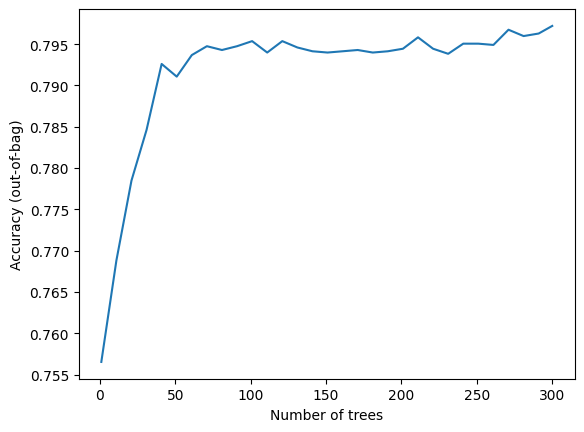

In [233]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

In [234]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=6519, accuracy=0.7972081607608529, loss=0.5746598438847531, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [235]:
### Check validation set

In [236]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

3/3 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 0.8050
loss: 0.0000
accuracy: 0.8050


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [237]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [238]:
for k,v in inspector.variable_importances().items():
    print(f'Importance by {k}:')
    print(v)

Importance by INV_MEAN_MIN_DEPTH:
[("RoomService" (1; #10), 0.1664869171310418), ("Spa" (1; #13), 0.16638240992736242), ("CryoSleep" (1; #2), 0.16597815850478698), ("VRDeck" (1; #15), 0.1535670253261391), ("DeckSide" (4; #4), 0.13953632539614377), ("Cabin_num" (4; #1), 0.13575531569900898), ("FoodCourt" (1; #6), 0.13170829219420807), ("ShoppingMall" (1; #11), 0.1287560975842902), ("HomePlanet" (4; #9), 0.11299972113503665), ("Age" (1; #0), 0.11007330422652291), ("Group" (4; #7), 0.10532298765379398), ("Deck" (4; #3), 0.10178441202642202), ("Destination" (4; #5), 0.09315522355131901), ("GroupSize" (1; #8), 0.08853275083389042), ("Side" (4; #12), 0.08827030682838873), ("VIP" (1; #14), 0.08213996853712581)]
Importance by NUM_AS_ROOT:
[("CryoSleep" (1; #2), 102.0), ("RoomService" (1; #10), 59.0), ("Spa" (1; #13), 47.0), ("VRDeck" (1; #15), 36.0), ("ShoppingMall" (1; #11), 24.0), ("FoodCourt" (1; #6), 20.0), ("DeckSide" (4; #4), 6.0), ("Deck" (4; #3), 4.0), ("Group" (4; #7), 1.0), ("HomePla

In [239]:
# Extract the top 5 from each metric and deduplicate
top_3 = []
for k,v in inspector.variable_importances().items():
    top_3.extend([r[0][0] for r in v][:3])

top_3 = set(list(top_3))

print(f'Top 3 features of each metric by importance and deduplicated:')
for r in top_3:
    print(f'{r}')

Top 3 features of each metric by importance and deduplicated:
Spa
Age
CryoSleep
RoomService
Cabin_num
DeckSide


# Submission

In [240]:
# Drop unwanted
for col in ['PassengerId', 'Name', 'Cabin']:
    try:
        test_df = test_df.drop(col, axis=1)
    except KeyError:
        print(f"Field {col} does not exist")

test_df["VIP"] = test_df["VIP"].apply(convert_bool_to_int)
test_df["CryoSleep"] = test_df["CryoSleep"].apply(convert_bool_to_int)

In [241]:
## Convert to TDF dataset

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

In [242]:
## Predict

predictions = rf.predict(test_ds)

# Convert the predictions to Boolean
n_predictions = (predictions > 0.5).astype(bool)
n_predictions

5/5 [==============================] - 0s 29ms/step


array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [246]:
## Submit
submission = pd.DataFrame({'PassengerId': test_idx, 'Transported': n_predictions.flatten()})
submission.to_csv(f'submissions/{model}-submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!
